In [12]:
import os
from pathlib import Path
from harp_resources import process, utils
import import_ipynb
import contextlib
import io
# Create a context manager to suppress output
f = io.StringIO()
with contextlib.redirect_stdout(f), contextlib.redirect_stderr(f):
    from Reading_H5files import Grab_data


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [14]:
#Grab_data.rename(columns={"movementX ": "movementX"}, inplace = True)
# Converst running units to cm / second
Grab_data.movementX = process.running_unit_conversion(Grab_data.movementX)*100
Grab_data.movementY = process.running_unit_conversion(Grab_data.movementX)*100


# Reset the index, which will convert the MultiIndex into columns
Grab_data = Grab_data.reset_index()
Grab_data = Grab_data.drop(columns=['level_0'])  # Assuming the column name is 'level_0' after reset_index()
Grab_data = Grab_data.set_index('level_1')  # 'level_1' will be the numeric index part
Grab_data.index.name = 'Time'



In [15]:
#Getting seconds from 0
Grab_data['TimeStamp'] = Grab_data.index - Grab_data.index[0]
Grab_data.rename(columns={"TimeStamp": "Seconds"}, inplace = True)


In [37]:
Grab_data.ExperimentEvents.unique()

array([nan, 'Sync signal started', 'LinearNormal block started',
       'Homing platform', 'Wait for run threshold...',
       'Block timer elapsed', 'Halt delay: 1s', 'Apply halt: 1s',
       'LinearMismatch block started'], dtype=object)

In [57]:
Grab_data['LinearRegular_block'] = False

# Get the start and end points based on 'ExperimentEvents', but use the index instead of 'Seconds'
start_idx = Grab_data.index[Grab_data['ExperimentEvents'] == 'Block timer elapsed'][0] + 1
end_idx = Grab_data.index[Grab_data['ExperimentEvents'] == 'LinearMismatch block started'][0] - 1

# Use .loc to update the 'LinearRegular_block' column based on the index condition
Grab_data.loc[(Grab_data.index > start_idx) & (Grab_data.index < end_idx), 'LinearRegular_block'] = True
Grab_data.loc[Grab_data['LinearRegular_block']==True]


,470_dfF,movementX,movementY,event,Seconds,eye_x,eye_y,pupil_diameter,ExperimentEvents,Experiment,Session,mouseID,sex,area,LinearNormal_block,LinearMismatch_block,LinearRegular_block
Time,,,,,,,,,,,,,,,,,
353973.1604,0.603410,0.003097,0.000066,True,642.5281,-25.422362,-16.862715,21.160475,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True
353973.1605,0.603508,0.003095,0.000066,True,642.5282,-25.420460,-16.859557,21.161432,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True
353973.1606,0.603607,0.003093,0.000065,True,642.5283,-25.418558,-16.856399,21.162390,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True
353973.1607,0.603705,0.003091,0.000065,True,642.5284,-25.416656,-16.853241,21.163348,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True
353973.1608,0.603804,0.003089,0.000065,True,642.5285,-25.414754,-16.850083,21.164306,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354600.5998,-0.157652,0.003515,0.000074,True,1269.9675,-20.101627,-12.180258,20.616313,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True
354600.5999,-0.157577,0.003513,0.000074,True,1269.9676,-20.110161,-12.183445,20.616068,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True
354600.6000,-0.157503,0.003512,0.000074,True,1269.9677,-20.118695,-12.186633,20.615823,NaN,MMclosed-and-Regular,day1,B3M6,F,V2M,False,False,True


In [ ]:
#There is a halt whenever the photodiote signal saved in 'event' column is False
Grab_data['event'].loc[Grab_data['event']==True]
Grab_data['halt'] = (Grab_data['event']==False)

event_starts = (Grab_data['halt'] & ~Grab_data['halt'].shift(1, fill_value=True))  # Detect where True starts
event_ends = (~Grab_data['halt'] & Grab_data['halt'].shift(1, fill_value=False))  # Detect where True ends

In [ ]:
Grab_data['Seconds'].loc[event_starts==True]

In [62]:
def norm(x, min, max):
    normal = (x-min)/(max-min)
    return normal

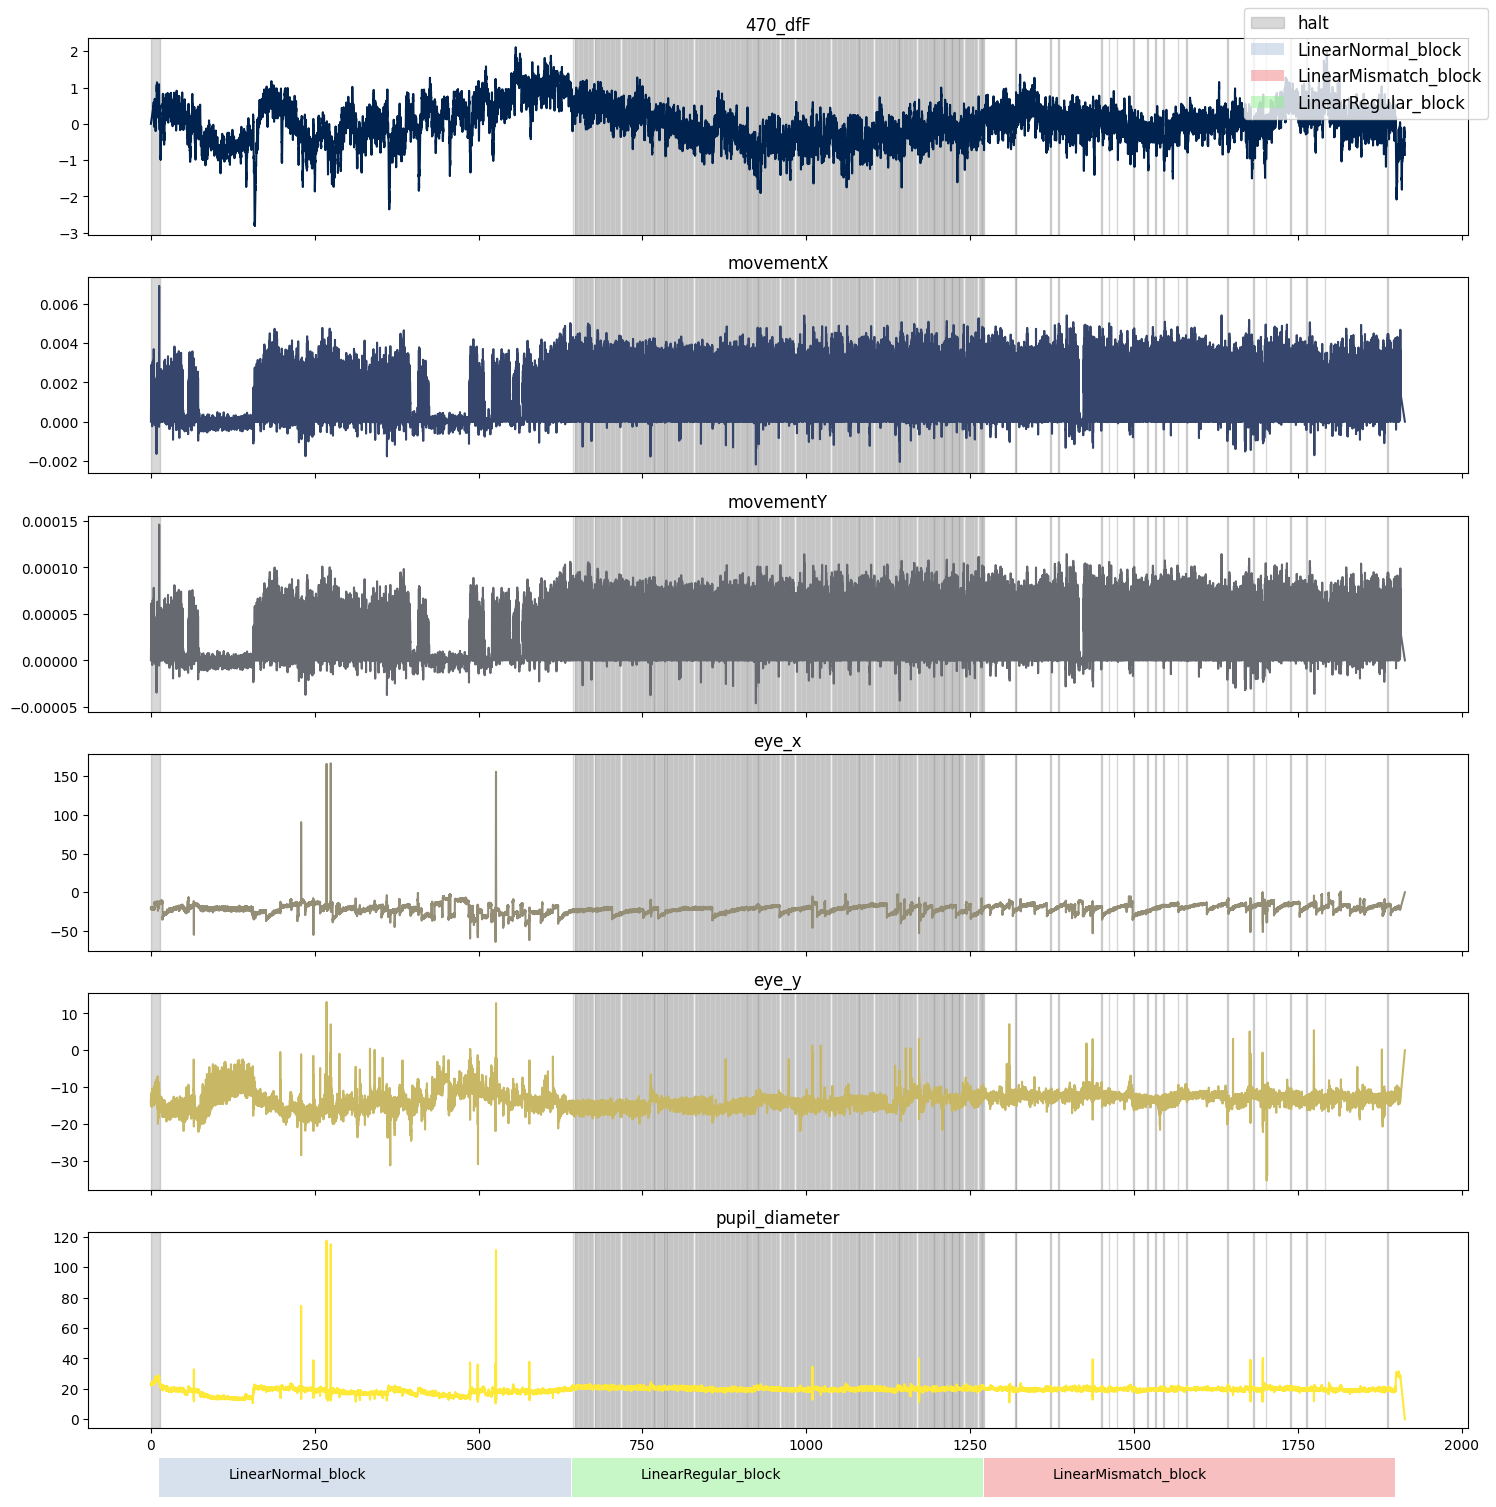

In [65]:
plotlist = ['470_dfF', 'movementX', 'movementY', 'eye_x', 'eye_y', 'pupil_diameter']

fig, axs = plt.subplots(len(plotlist), figsize=(15,15), sharex=True)  # sharex=True for a shared x-axis
color = plt.cm.cividis(np.linspace(0, 1, len(plotlist)))

# Iterate over the subplots and plot the traces
for i, (ax, trace) in enumerate(zip(axs, plotlist)):
    ax.plot(Grab_data.Seconds, Grab_data[trace], color=color[i])
    ax.set_title(trace)
    
    
    # Plot shaded areas for each halt event

    for start, end in zip(Grab_data['Seconds'].loc[event_starts==True], Grab_data['Seconds'].loc[event_ends==True]):
        # Add the grey patches (label only the first one for the legend)
    
        halt = ax.axvspan(start, end, color='grey', alpha=0.3)


halt.set_label('halt')

# Plot a horizontal line for LinearNormal_block and LinearMismatch_block on a shared x-axis at the bottom
# We use the last axis (axs[-1]) to plot these lines, but we can adjust their y-position below the subplots
#trans = ax.get_xaxis_transform()
block_colors = ['lightsteelblue', 'lightcoral', 'forestgreen']
colorcount = 0
for col in Grab_data:
    if '_block' in col:
        start = Grab_data['Seconds'].loc[Grab_data[col] == True].iloc[0]
        end = Grab_data['Seconds'].loc[Grab_data[col] == True].iloc[-1]

        min = ax.get_xlim()[0]
        max = ax.get_xlim()[1]

        norm_start = norm(start, min, max)
        norm_end = norm(end, min, max)

        ax.text(norm_start+0.05, -0.2, col, transform=ax.transAxes,fontsize=10, verticalalignment='top')

        ax.add_patch(Rectangle((norm_start, -0.15), norm_end - norm_start, -0.2, facecolor= block_colors[colorcount],
                               alpha = 0.5, label=col, clip_on = False, transform=ax.transAxes))# **kwargs))
        
        #plt.hlines(-20,xmin=start, xmax=end, linewidth=5, color=colorlist[colorcount], alpha = 0.5, label= f'{col}')
        colorcount+=1

# Create one legend for the figure for the 'halt' label
fig.legend(loc='lower right', fontsize=12)

# Update font size and layout
plt.rcParams.update({'font.size': 10})
fig.tight_layout(pad=1.08)
plt.show()


31.883333333333333